In [4]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
import joblib
from scipy.special import softmax
import sasc.config
import numpy as np
from collections import defaultdict
from copy import deepcopy
import pandas as pd
import imodelsx.linear_finetune
from sasc import analyze_helper
from sasc.modules.fmri_module import convert_module_num_to_voxel_num
from sasc.config import FMRI_DIR, RESULTS_DIR
import dvu
dvu.set_style()
story_data = joblib.load(join(sasc.config.RESULTS_DIR, 'pilot_story_data.pkl'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load data and corresponding resps
pilot_data_dir = '/home/chansingh/mntv1/deep-fMRI/story_data/20230504'
resp_np_files = sorted(os.listdir(pilot_data_dir))
resps_dict = {
    k: np.load(join(pilot_data_dir, k))
    for k in tqdm(resp_np_files)
}

# pcs = joblib.load(join(FMRI_DIR, "voxel_neighbors_and_pcs", "loo_pc_UTS02.pkl"))
# pcs['good_voxels'].shape
# pcs['pca_projections'].shape

100%|██████████| 6/6 [00:21<00:00,  3.63s/it]


In [5]:
mats = defaultdict(list)
for use_clusters in [False, True]:
    for story_num in [0, 1, 2, 3, 4, 5]:
        rows = story_data["rows"][story_num]

        # get resp_chunks
        resp_story = resps_dict[
            story_data["story_name_new"][story_num]
        ].T  # (voxels, time)
        timing = story_data["timing"][story_num]
        paragraphs = story_data["story_text"][story_num].split("\n\n")
        assert len(paragraphs) == len(rows)
        resp_chunks = analyze_helper.get_resp_chunks(timing, paragraphs, resp_story)

        # calculate mat
        mat = np.zeros((len(rows), len(paragraphs)))
        for i in range(len(paragraphs)):
            if use_clusters == False:
                mat[:, i] = resp_chunks[i][rows["voxel_num"].values].mean(axis=1)
            elif use_clusters == True:
                for r in range(len(rows)):
                    cluster_nums = rows.iloc[r]["cluster_nums"]
                    if isinstance(cluster_nums, np.ndarray):
                        vals = resp_chunks[i][cluster_nums].flatten()
                        mat[r, i] = np.nanmean(vals)
                    else:
                        # print(cluster_nums)
                        mat[r, i] = np.nan
        mat[:, 0] = np.nan  # ignore the first column
        # print('mat', mat)

        # sort by voxel_num
        args = np.argsort(rows["voxel_num"].values)
        mat = mat[args, :][:, args]
        mats[use_clusters].append(deepcopy(mat))

        # plt.imshow(mat)
        # plt.colorbar(label="Mean response")
        # plt.xlabel("Corresponding paragraph\n(Ideally, diagonal should be brighter)")
        # plt.ylabel("Voxel")
        # plt.title(f"{story_data['story_name_new'][story_num][3:-10]}")
        # plt.show()
rows = rows.sort_values(by="voxel_num")
expls = rows["expl"].values



m = {}
for use_clusters in [False, True]:
    mats[use_clusters] = np.array(mats[use_clusters])  # (6, 17, 17)
    m[use_clusters] = np.nanmean(mats[use_clusters], axis=0)

/tmp/ipykernel_3424862/1884219528.py:51: RuntimeWarning: Mean of empty slice
  m[use_clusters] = np.nanmean(mats[use_clusters], axis=0)


### Make average plot

<>:25: DeprecationWarning: invalid escape sequence '\s'
<>:25: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_3424862/2388444545.py:25: DeprecationWarning: invalid escape sequence '\s'
  plt.ylabel('Mean voxel response ($\sigma_f$)')


measurements
food preparation
mean 0.30668354025334005


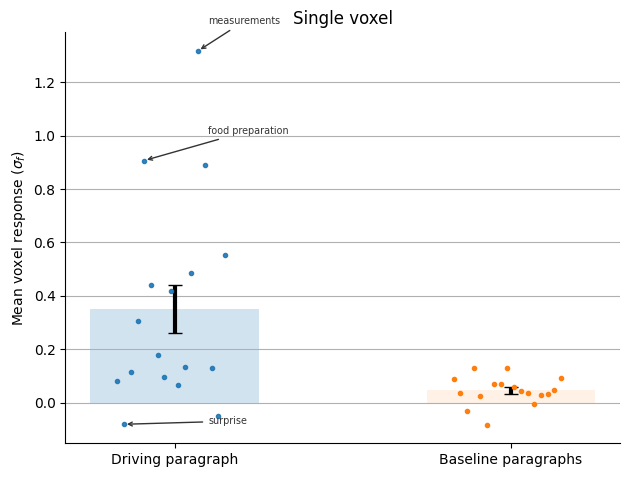

In [9]:
# calculate means
use_clusters = False
m1 = m[use_clusters]

n = m1.shape[0]
diag_means = np.diag(m1)
diag_mean = np.nanmean(diag_means)

# get mean of each row excluding the diagonal
off_diag_means = np.nanmean(m1, axis=1) - (diag_means / n)
off_diag_mean = np.nanmean(off_diag_means)


# make plot
x = np.arange(n) - n / 2
plt.bar(1, diag_mean, width=0.5, label='Diagonal', alpha=0.2, color='C0')
plt.errorbar(1, diag_mean, yerr=np.nanstd(diag_means) / np.sqrt(len(diag_means)), fmt='.', label='Diagonal', ms=0, color='black', elinewidth=3, capsize=5, lw=1)
plt.plot(1 + x/50, diag_means, '.', color='C0', alpha=0.9)

plt.bar(2, off_diag_mean, width=0.5, label='Off-diagonal', alpha=0.1, color='C1')
plt.errorbar(2, off_diag_mean, yerr=np.nanstd(off_diag_means) / np.sqrt(len(off_diag_means)), fmt='.', label='Diagonal', ms=0, color='black', elinewidth=3, capsize=5)
plt.plot(2 + x/50, off_diag_means, '.', color='C1')

plt.xticks([1, 2], ['Driving paragraph', 'Baseline paragraphs'])
plt.ylabel('Mean voxel response ($\sigma_f$)')
plt.grid(axis='y')

# annotate the point with the highest mean
kwargs = dict(
    arrowprops=dict(arrowstyle='->', color='#333'), fontsize='x-small', color='#333'
)
idx = np.argmax(diag_means)
print(expls[idx])
plt.annotate(f"{expls[idx]}", (1 + x[idx]/50, diag_means[idx]), xytext=(1.1, diag_means[idx] + 0.1), **kwargs)

# annotate the point with the second highest mean
idx = np.argsort(diag_means)[-2]
print(expls[idx])
plt.annotate(f"{expls[idx]}", (1 + x[idx]/50, diag_means[idx]), xytext=(1.1, diag_means[idx] + 0.1), **kwargs)

# annotate the point with the lowest mean
idx = np.argmin(diag_means)
plt.annotate(f"{expls[idx]}", (1 + x[idx]/50, diag_means[idx]), xytext=(1.1, diag_means[idx]), **kwargs)
plt.tight_layout()
print('mean', diag_mean - off_diag_mean)
# plt.title(f'use_clusters={use_clusters}')
plt.title('Single voxel')
plt.savefig(join(RESULTS_DIR, 'pilot_means.pdf'))

In [39]:
rows[['expl', 'module_num']].reset_index().iloc[np.argsort(diag_means)[::-1]].module_num.values

array([171,  79, 299, 122, 339, 212, 398, 426, 442, 337, 368, 342, 248,
       179, 155, 154, 168])

### Relationship between different voxels

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 17/17 [00:00<00:00, 128.27it/s]


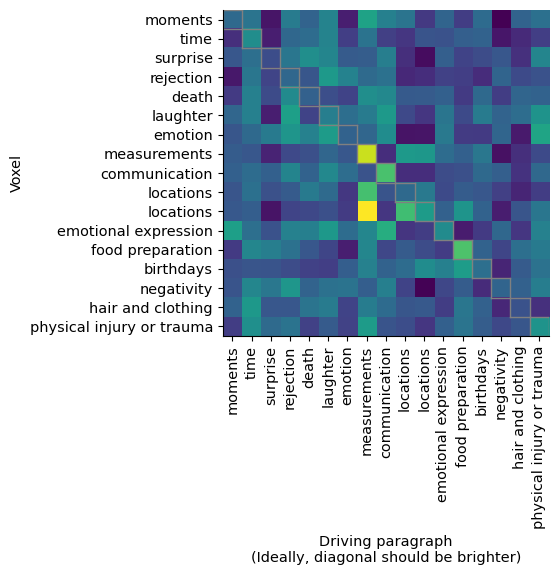

In [61]:
# note: some voxels didn't have good clusters so they will be missing from these plots...
use_clusters = False
m1 = m[use_clusters]
# cg = sns.clustermap(pd.DataFrame(m, columns=expls, index=expls), method='complete', cmap='viridis', figsize=(10, 10))
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.xlabel('Driving paragraph')
plt.figure(figsize=(6, 6))
# m = softmax(m, axis=0)


for r in range(m1.shape[0]):
    for c in range(m1.shape[1]):
        # outline the diagonal
        if r == c:
            plt.plot([r - 0.5, r + 0.5], [c - 0.5, c - 0.5], color='gray', lw=1)
            plt.plot([r - 0.5, r + 0.5], [c + 0.5, c + 0.5], color='gray', lw=1)
            plt.plot([r - 0.5, r - 0.5], [c - 0.5, c + 0.5], color='gray', lw=1)
            plt.plot([r + 0.5, r + 0.5], [c - 0.5, c + 0.5], color='gray', lw=1)
        

expls_order = analyze_helper.sort_expls_semantically(expls)
m_plot = m1[expls_order][:, expls_order] #[:, expls_order]
# m_plot = m1
plt.imshow(m_plot)
plt.xlabel("Driving paragraph\n(Ideally, diagonal should be brighter)", fontsize='x-small')
plt.ylabel("Voxel", fontsize='x-small')
plt.yticks(labels=expls[expls_order], ticks=np.arange(len(expls)), fontsize='x-small')
plt.xticks(labels=expls[expls_order], ticks=np.arange(len(expls)), rotation=90, fontsize='x-small')
plt.show()

# plot correlations across all resps
# resps_voxels = np.concatenate(
#     [resps_dict[story_data["story_name_new"][story_num]].T for story_num in [2, 3, 4]],
#     axis=1,
# )[rw["voxel_num"].values]
# corr = pd.DataFrame(resps_voxels.T, columns=expls).corr().round(2)
# sns.clustermap(corr)

### Story-level differences

In [ ]:
use_clusters = False
mats1 = mats[use_clusters]

d = defaultdict(list)
for i in range(len(mats1)):
    m = mats1[i]
    d['driving'].append(np.nanmean(np.diag(m)))
    d['baseline'].append(np.nanmean(m[~np.eye(m.shape[0], dtype=bool)]))
    d['story'].append(story_data['story_name_new'][i][3:-10])

df = pd.DataFrame.from_dict(d)

# make barplot comparing driving and baseline
df = df.melt(id_vars='story', value_vars=['driving', 'baseline'], var_name='condition', value_name='mean')
df = df.sort_values(by='story')
sns.barplot(data=df, x='story', y='mean', hue='condition')
plt.ylabel('Mean voxel response ($\sigma_f$)')
plt.show()

### Voxel-level differences

In [ ]:
rw = rw.sort_values(by="voxel_num")
rw['mean_resp_diff'] = diag_means # - off_diag_means

# ax = sns.pairplot(rw, vars=['mean_resp_diff', 'top_score_synthetic', 'fmri_test_corr'], hue='expl')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1.01, 1))

plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1)
plt.plot(rw['top_score_synthetic'], rw['mean_resp_diff'], 'o')
plt.ylabel('Mean voxel response')
plt.xlabel('Synthetic score')

plt.subplot(1, 2, 2)
plt.plot(rw['fmri_test_corr'], rw['mean_resp_diff'], 'o')
plt.xlabel('Predicted test correlation')

plt.tight_layout()
plt.show()